In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.family'] = 'Times New Roman'
import seaborn as sns
import yfinance as yf
from scipy.stats import skew, kurtosis

import sys, os
sys.path.append(os.path.abspath(os.path.join('..', '..', 'src')))
from pca.PCARiskAllocator import PCARiskAllocator

# PCARiskAllocator

`PCARiskAllocator` is a PCA-based portfolio risk allocation tool.  
The main idea is to decompose the covariance matrix of asset returns into principal components,  
and then allocate portfolio risk across these components according to a chosen scheme.

---

## Mathematical Background

Given the covariance matrix of asset returns, $\Sigma$, we perform an eigen-decomposition:

$$
\Sigma = V \Lambda V^\top
$$

- $\Lambda = \mathrm{diag}(\lambda_1, \lambda_2, \dots, \lambda_n)$ contains the eigenvalues (variances of the principal components).  
- $V = [v_1, v_2, \dots, v_n]$ is the matrix of eigenvectors (directions of the components).

A **risk allocation vector** $\delta = (\delta_1, \dots, \delta_n)$ is chosen such that:  
$\delta_i \geq 0$ and $\sum_i \delta_i = 1$.

The loading on each principal component in the original formula is defined as:

$$
l_i = \frac{\sqrt{\delta_i}}{\sqrt{\lambda_i}}
$$

In this implementation, the loadings are additionally scaled by the target volatility $\sigma^*$:

$$
l_i = \sigma^* \cdot \frac{\sqrt{\delta_i}}{\sqrt{\lambda_i}}
$$

The portfolio weights are then obtained as:

$$
w = V \, l
$$

where $l = (l_1, \dots, l_n)^\top$.

The portfolio volatility is:

$$
\sigma_p = \sqrt{w^\top \Sigma w}
$$

Finally, the weights are scaled to match a target volatility $\sigma^*$:

$$
w^* = w \cdot \frac{\sigma^*}{\sigma_p}
$$

---

### Why PCA Risk Allocation?

- Identifies the main sources of portfolio risk.  
- Controls the contribution of each hidden risk factor to total variance.  
- Builds weights that balance exposures across factors, not only across individual assets.  

This approach is particularly useful when dealing with **many assets but limited observations**,  
or when the goal is to manage **latent risk exposures** instead of raw asset weights.


# 1. Download Data

In [3]:
assets_path = r'../../data/100 close prices 5Y.csv'

In [4]:
close = pd.read_csv(assets_path).set_index('date').dropna().iloc[:-1]
returns = (close / close.shift(1)).dropna()
logs = np.log(returns)

# 2. Initialize ```PCARiskAllocator```

When creating a new `PCARiskAllocator` instance, two parameters must be specified:

- **`returns`** (`np.ndarray`)  
  A NumPy array of asset return series with shape `(T, N)`, where `T` is the number of time periods and `N` is the number of assets.  
  This input is required and must be provided as a **NumPy array** - other data structures (e.g., Pandas DataFrame) are not accepted directly.

- **`logs`** (`bool`, default=`True`)  
  A Boolean flag indicating the type of returns provided:  
  - `True` → The input `returns` are already **log returns**.  
  - `False` → The input is given as **simple/raw returns**, and the class will automatically convert them into log returns using `np.log()`.  

🔎 **Note:** Internally, the class always works with log returns. Even if raw returns are passed, they will be transformed before any calculations (covariance, PCA decomposition, weights).

In [5]:
pra = PCARiskAllocator(returns=logs.values,
                      logs=True)
pra

PCARiskAllocator(assets=100) | PCA: not fitted

## 2.1 Fit the Model

The `.fit()` method estimates the covariance matrix, performs PCA decomposition, applies the chosen risk allocation scheme, and computes the portfolio weights scaled to the desired target volatility.

### Parameters

- **`risk_target`** (`float`, required)  
  Target portfolio volatility (standard deviation).  
  All portfolio weights are scaled so that the resulting portfolio volatility equals this value.

- **`allocation`** (`str`, default=`'minvar'`)  
  Method for distributing risk across principal components. Supported options:  
  - `'minvar'`: Allocate all risk to the **last principal component** (lowest variance).  
  - `'equal'`: Allocate equal risk to all components.  
  - `'proportional'`: Allocate risk in proportion to each eigenvalue (variance explained).  
  - `'inverse'`: Allocate risk inversely proportional to each eigenvalue.  

- **`cov_method`** (`str`, default=`'ledoit'`)  
  Method used to estimate the covariance matrix:  
  - `'ledoit'`: Ledoit-Wolf shrinkage estimator.  
  - `'sample'`: Standard sample covariance estimator.  

---

### Internal Workflow

1. Estimate covariance matrix $\Sigma$ using the selected `cov_method`.  
2. Compute eigen-decomposition: $\Sigma = V \Lambda V^\top$.  
3. Construct a **risk allocation vector** $\delta = (\delta_1, \dots, \delta_n)$ based on the chosen `allocation` scheme.  
4. Compute component loadings:  
   $$
   l_i = \sigma^* \cdot \frac{\sqrt{\delta_i}}{\sqrt{\lambda_i}}
   $$  
5. Form raw portfolio weights:  
   $$
   w = V l
   $$  
6. Normalize weights to exactly match the target volatility $\sigma^*$.  

---

After fitting, the optimizer is ready to provide portfolio weights and other diagnostics via its properties (e.g., `.weights`, `.sigma`).


### Allocation Strategies (Risk Allocation Schemes)

The `allocation` parameter determines how the total risk is allocated across principal components.  
Formally, it defines the risk allocation vector $\delta = (\delta_1, \dots, \delta_n)$ such that $\delta_i \geq 0$ and $\sum_i \delta_i = 1$.

---

- **`'minvar'`** – All risk is allocated to the *last* principal component (the one with the lowest eigenvalue $\lambda_n$).  

  $$
  \delta_i = 
  \begin{cases}
  1 & i = n \\
  0 & i \neq n
  \end{cases}
  $$

---

- **`'equal'`** – Risk is split equally among all components.  

  $$
  \delta_i = \frac{1}{n}, \quad i = 1, \dots, n
  $$

---

- **`'proportional'`** – Risk is distributed proportionally to the variance explained by each component (its eigenvalue).  

  $$
  \delta_i = \frac{\lambda_i}{\sum_{j=1}^n \lambda_j}
  $$

---

- **`'inverse'`** – Risk is distributed inversely proportional to the variance of each component, giving more weight to low-variance directions.  

  $$
  \delta_i = \frac{\tfrac{1}{\lambda_i}}{\sum_{j=1}^n \tfrac{1}{\lambda_j}}
  $$


In [6]:
RT = 0.1
pra.fit(risk_target=RT, allocation='inverse')

In [7]:
pra

PCARiskAllocator(assets=100) | PCA: sigma=0.1000

# 3. Attributes

## 3.1 `evalues`, `evectors`

After fitting the model, the PCA decomposition of the covariance matrix is available through two attributes:

- **`pra.evalues`** (`np.ndarray`)  
  The eigenvalues $\lambda_1, \dots, \lambda_n$ of the covariance matrix.  
  Each eigenvalue represents the variance explained by the corresponding principal component.  
  Larger values indicate directions of higher variance in the data, while smaller values capture low-variance directions.

- **`pra.evectors`** (`np.ndarray`)  
  The eigenvectors $v_1, \dots, v_n$ corresponding to the eigenvalues.  
  Each eigenvector defines a principal component, i.e., a linear combination of the original assets.  
  Together, they form an orthonormal basis:  
  $$
  \Sigma = V \Lambda V^\top
  $$
  where $V = [v_1, v_2, \dots, v_n]$ and $\Lambda = \mathrm{diag}(\lambda_1, \dots, \lambda_n)$.

---

🔎 **Usage**  
- `evalues` is useful for analyzing how much variance is captured by each component.  
- `evectors` provides the loadings (weights) of each asset on each principal component, allowing factor interpretation.

In [8]:
evalues = pra.evalues
evectors = pra.evectors
print(f'Eigen Values: {evalues[:5]}...\ntotal = {len(evalues)}\n')
print(f'Eigen Values:\n{evectors[:5, :5]}...\ntotal = {len(evectors)}')

Eigen Values: [0.01269997 0.00351883 0.00186957 0.00104939 0.00088082]...
total = 100

Eigen Values:
[[ 0.1119128   0.1007266  -0.05166945  0.04476281 -0.02027664]
 [ 0.10177424  0.12031828 -0.04837158 -0.01489699  0.052731  ]
 [ 0.11064943  0.1076504  -0.01358535 -0.00858407  0.09525662]
 [ 0.12695305  0.15882046 -0.00704944  0.02610647  0.16044663]
 [ 0.14146298  0.17792024 -0.01903375 -0.02985176  0.32333605]]...
total = 100


## 3.2 `sigma`

- **`pra.sigma`** (`float`)  
  The realized portfolio volatility (standard deviation) after fitting the model.  

This attribute reflects the **actual portfolio risk** computed from the covariance matrix and the optimized weights.  
By construction, it should match the target risk level `risk_target` specified in `.fit()`:

$$
\sigma_p = \sqrt{w^\top \Sigma w}
$$

where $w$ are the final portfolio weights.

---

🔎 **Usage**  
- Compare the input `risk_target` with `pra.sigma` to confirm that scaling has been applied correctly.  
- Ensures that the optimizer delivers a portfolio whose volatility is exactly aligned with the user-specified target.

In [9]:
risk = pra.sigma
print(f'Target Risk: {RT}')
print(f'Portfolio Risk: {risk:.4f}')

Target Risk: 0.1
Portfolio Risk: 0.1000


## 3.3 `weights`

- **`pra.weights`** (`np.ndarray`)  
  The final portfolio weights vector $w = (w_1, \dots, w_n)$ obtained after fitting.  
  These represent the exposures assigned to each asset in order to achieve the desired risk allocation and match the target volatility.

---

### Mathematical Definition

The weights are computed as:

1. Construct loadings:  
   $$
   l_i = \sigma^* \cdot \frac{\sqrt{\delta_i}}{\sqrt{\lambda_i}}
   $$

2. Map loadings back to asset space using eigenvectors:  
   $$
   w = V l
   $$

3. Normalize to ensure portfolio volatility equals the target:  
   $$
   w^* = w \cdot \frac{\sigma^*}{\sqrt{w^\top \Sigma w}}
   $$

---

🔎 **Notes**  
- The weights can take **positive or negative values**, meaning both long and short positions are possible.  
- By design, the sum of weights does **not necessarily equal 1**; the scaling is driven by risk targeting, not by a budget constraint.  
- This is a **risk-based allocation**, not a traditional long-only portfolio optimization.


In [10]:
pra.weights

array([ 4.45880008e-01, -7.91299937e-01,  9.32638818e-01, -5.30703286e-01,
       -2.90146660e-01,  9.46721386e-02, -4.68726304e-01, -2.96612238e+00,
       -4.28299173e-01,  1.87713310e+00,  1.60327252e+00, -2.85544789e+00,
       -3.48983230e-01, -1.10887312e+00, -3.22479913e+00,  1.23537345e+00,
       -1.39105776e+00,  4.33403063e+00,  4.30040467e-01, -2.53059232e-01,
       -1.48611845e-01,  6.30934901e-01,  3.28607585e-02,  1.04870361e+00,
        3.86267582e-01,  9.71611858e-01,  8.57078567e-01, -9.38239360e-01,
       -3.70205796e-01, -1.18863668e-01, -4.06799499e-03, -1.71613751e-01,
       -3.71579255e-01,  1.95959184e+00, -8.53994123e-01,  1.93869096e+00,
        4.00566351e-01,  2.18183162e-01,  9.16951050e-02,  1.03392657e+00,
       -7.22921729e-02, -1.77734754e+00, -1.75743685e+00, -8.81820131e-01,
        1.82130056e+00,  5.20245773e-01,  1.85187653e+00,  3.44524647e-01,
        3.77119754e-01, -1.11765749e+00,  2.51780825e-02,  1.12698422e+00,
        6.54908478e-01,  

## 3.4 `loadings`, `risk_contribution`

- **`pra.loadings`** (`np.ndarray`)  
  The scaling factors $l_i$ applied to each principal component, determined by the chosen risk allocation scheme and target volatility:  
  $$
  l_i = \sigma^* \cdot \frac{\sqrt{\delta_i}}{\sqrt{\lambda_i}}
  $$
  where $\delta_i$ is the allocated share of risk and $\lambda_i$ is the eigenvalue of the $i$-th principal component.

- **`pra.risk_contribution`** (`np.ndarray`)  
  The share of total portfolio risk contributed by each principal component.  
  By construction, these contributions sum to 1:
  $$
  \text{RC}_i = \frac{\delta_i}{\sum_{j=1}^n \delta_j}
  $$

---

### Visualization

The figure below shows:
- **Top panel:** Loadings per principal component.  
- **Bottom panel:** Risk contribution of each principal component.  

This allows clear inspection of which components drive the portfolio’s total risk.

In [11]:
loadings = pra.loadings
rc = pra.risk_contribution

df = pd.DataFrame({
    'Loadings': loadings,
    'Risk Contribution': rc
})

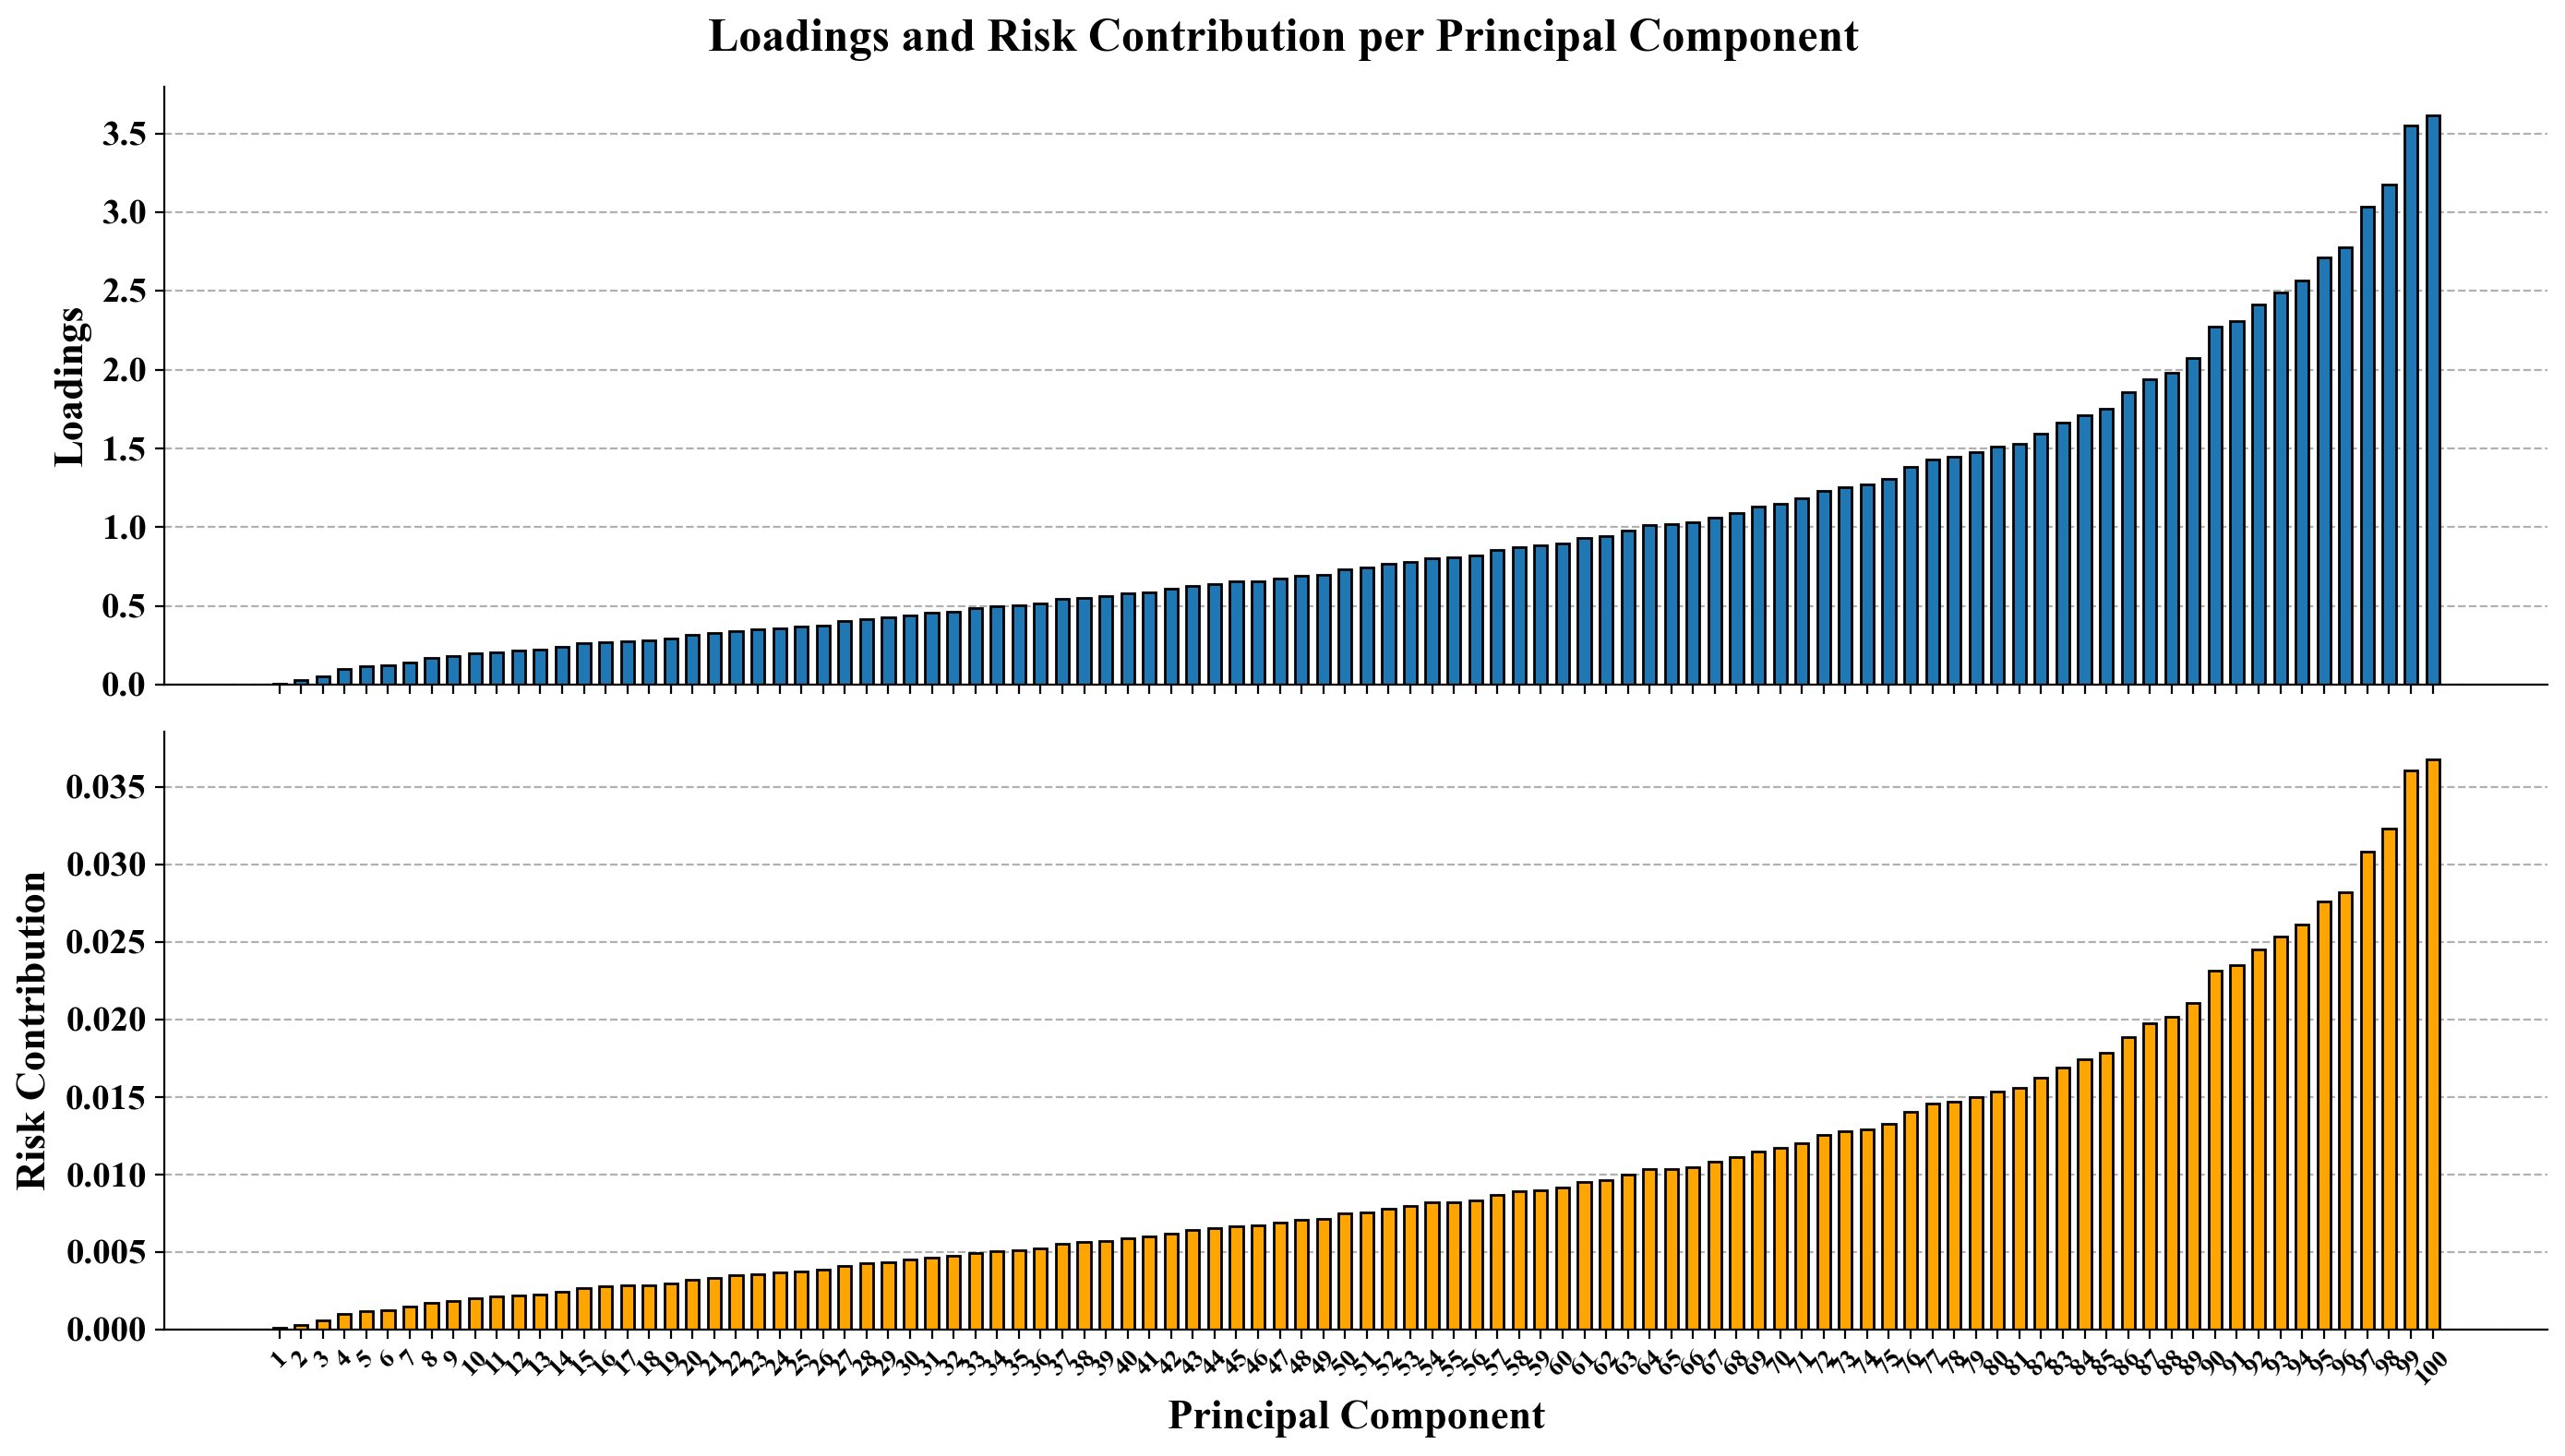

In [12]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), dpi=200, sharex=True)
x = np.arange(len(loadings))
width = 0.6

# Loadings
ax1.bar(x, loadings, width=width, edgecolor='k', zorder=2)
ax1.set_ylabel('Loadings', size=16, weight='bold')
for label in ax1.get_yticklabels():
    label.set_fontsize(14)
    label.set_weight('bold')
ax1.grid(ls='--', axis='y')


ax2.bar(x, rc, width=width, edgecolor='k', color='orange', zorder=2)
ax2.set_ylabel('Risk Contribution', size=16, weight='bold')
for label in ax2.get_yticklabels():
    label.set_fontsize(14)
    label.set_weight('bold')
ax2.grid(ls='--', axis='y')

ax2.set_xlabel('Principal Component', size=16, weight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels([f'{i+1}' for i in x], rotation=45, weight='bold')

fig.suptitle('Loadings and Risk Contribution per Principal Component', fontsize=18, weight='bold')
sns.despine()
fig.tight_layout()
plt.show()

# 4. Effect of `allocation` on Portfolio Returns

The parameter `allocation` controls how portfolio risk is allocated across principal components.  
To illustrate its impact, we compare the **log-returns** of portfolios constructed under the four available diversification schemes:

- `minvar`
- `equal`
- `proportional`
- `inverse`

Each portfolio is scaled to the same target volatility ($\sigma^* = 0.1$), ensuring comparability.

---

### Visualization

The figure below shows the time series of **log-returns** for the four diversification methods:

- **Top panel:** All risk concentrated in the lowest-variance component (`minvar`).  
- **Second panel:** Equal risk across all components (`equal`).  
- **Third panel:** Risk proportional to variance explained (`proportional`).  
- **Bottom panel:** More risk allocated to low-variance components (`inverse`).  

---

🔎 **Insight**  
Even though the target volatility is fixed at $\sigma^* = 0.1$, the *distribution of returns over time* changes substantially depending on the `allocation` scheme, reflecting different exposures to underlying risk factors.


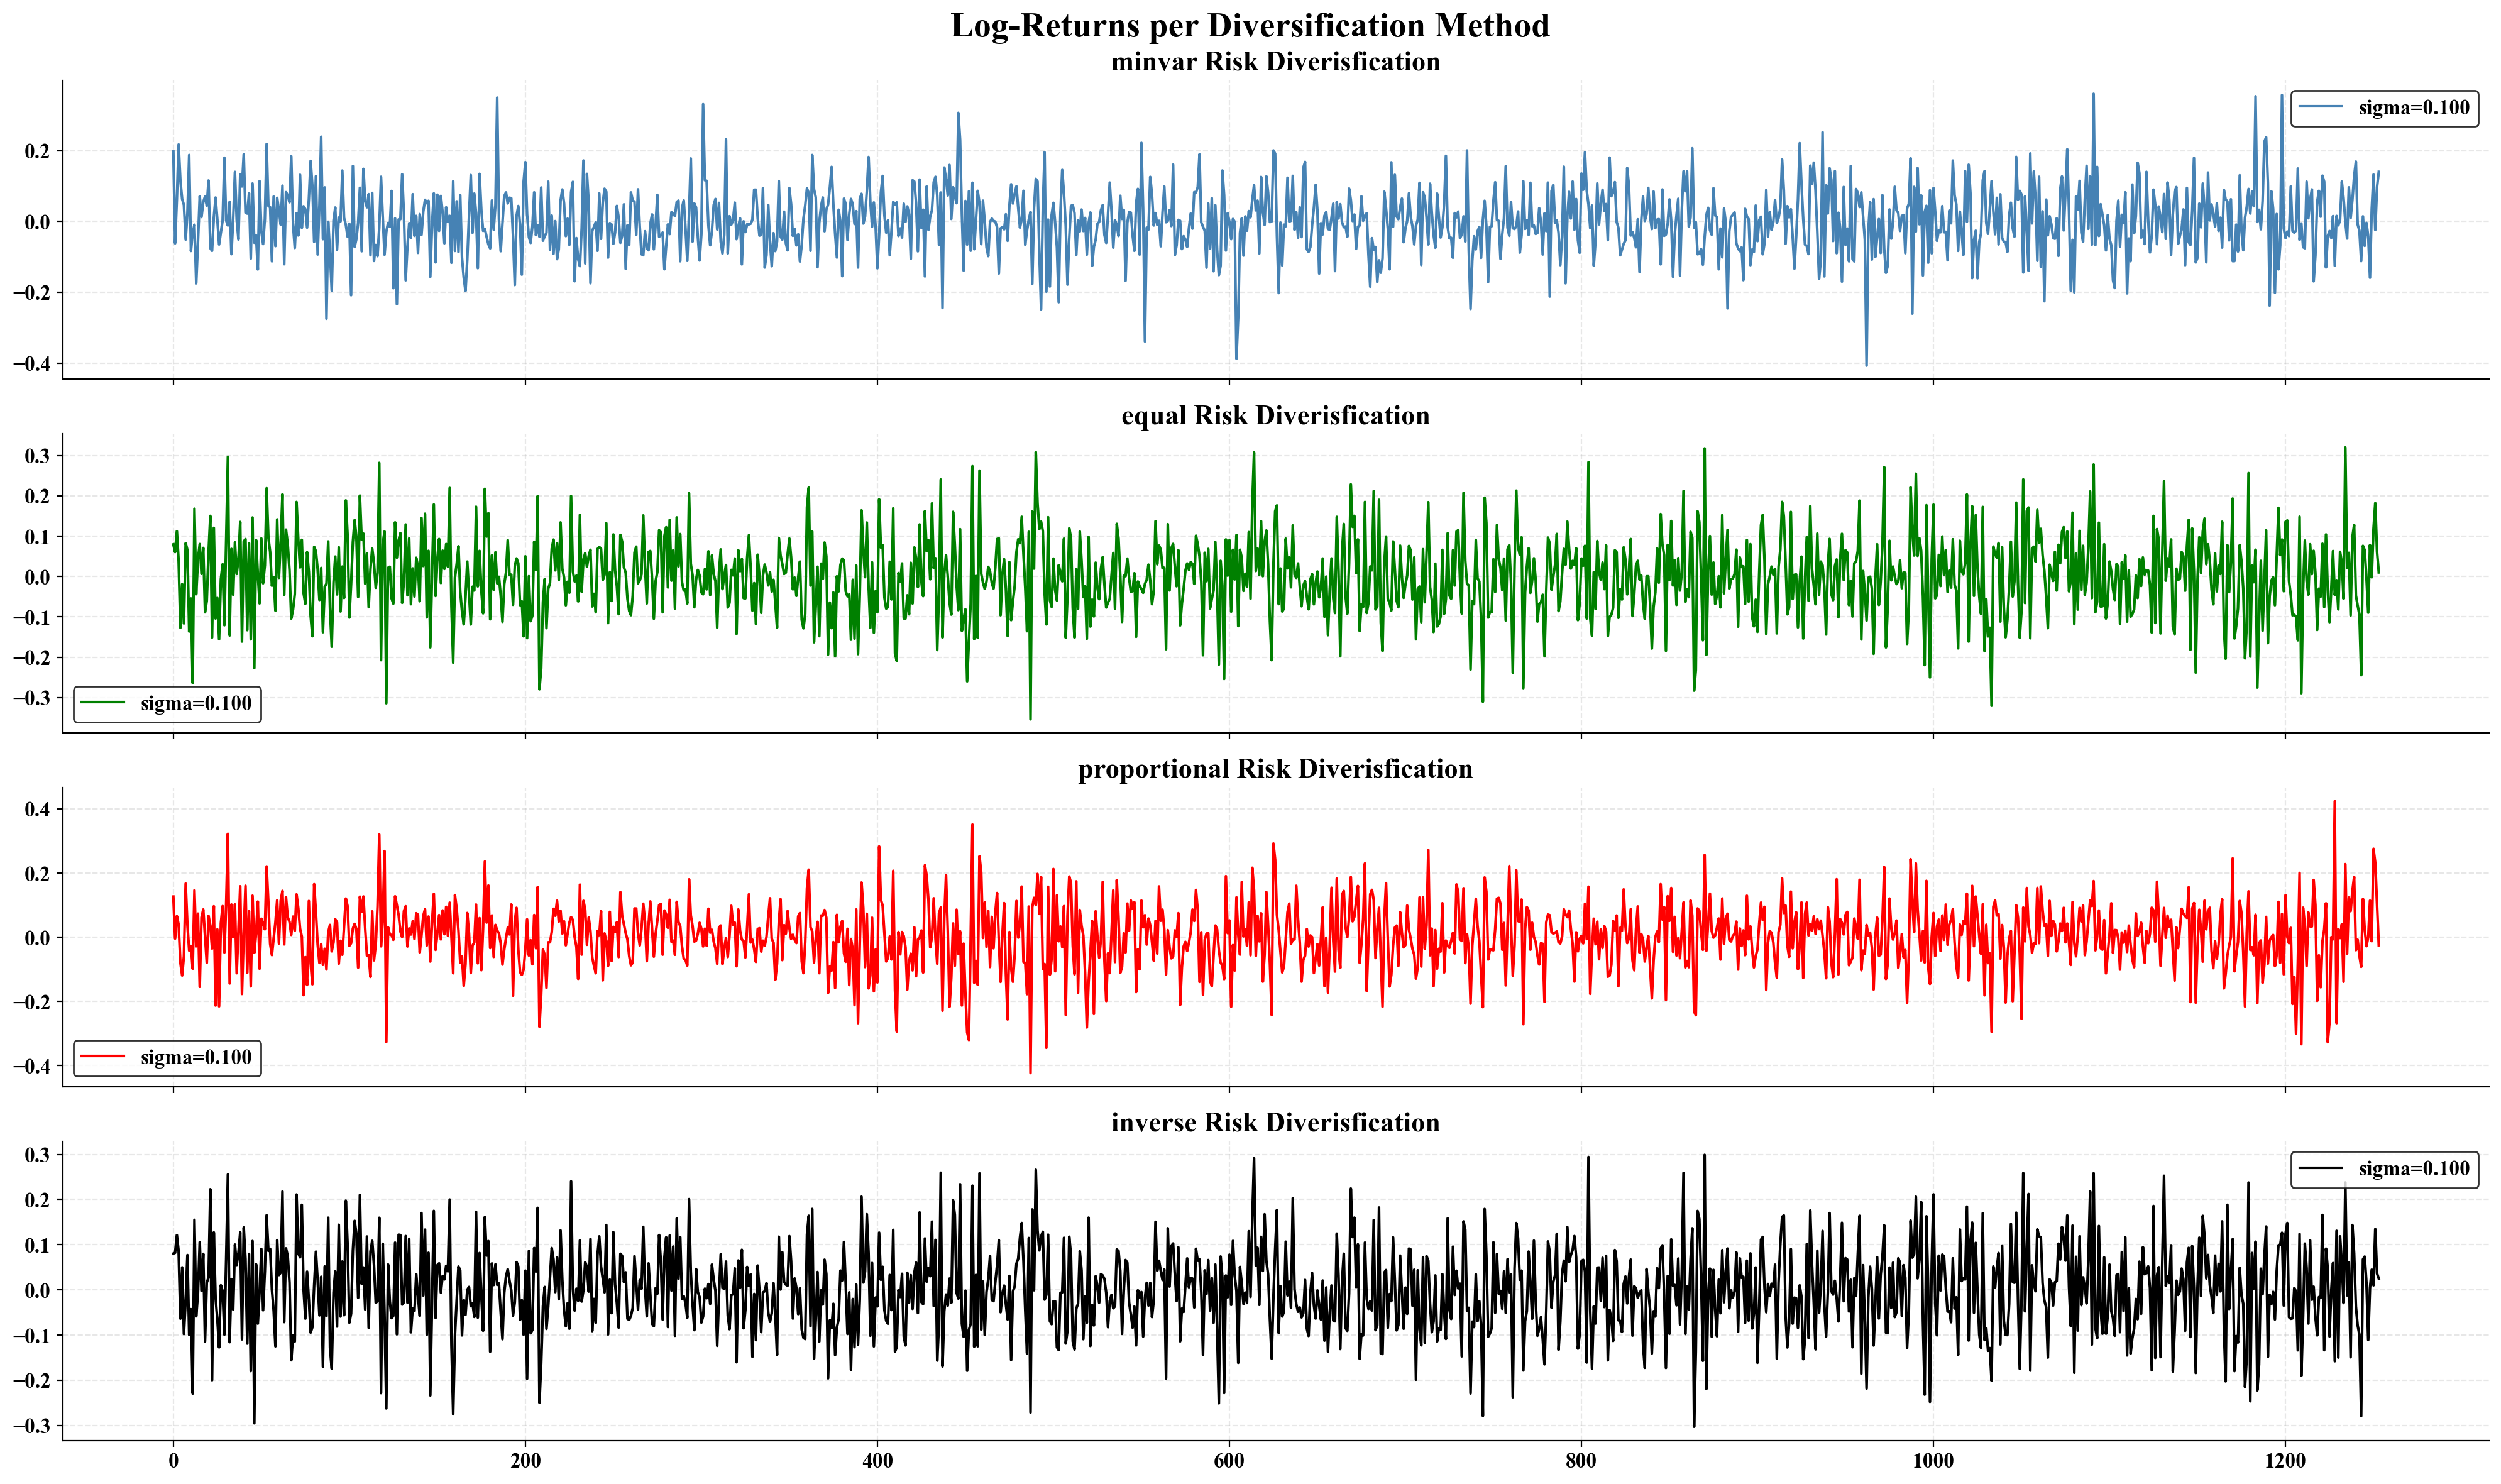

In [13]:
allocation = ['minvar', 'equal', 'proportional', 'inverse']
colors = ['steelblue', 'green', 'red', 'black']

pra_2 = PCARiskAllocator(logs.values,
                         logs=True)

fig, ax = plt.subplots(4, 1, figsize=(20,12), dpi=200, sharex=True)
for i, d in enumerate(allocation):
    pra_2.fit(risk_target=0.1,
              allocation=d)
    p = pra_2.portfolio
    ax[i].plot(p,
              color=colors[i],
              label=f'sigma={pra_2.sigma:.3f}')
    ax[i].set_title(f'{d} Risk Diverisfication',
                   size=16, weight='bold')
    ax[i].grid(ls='--', alpha=.3)
    ax[i].legend(edgecolor='k',
                 prop={'size': 12, 'weight':'bold'})

    for label in ax[i].get_yticklabels():
        label.set_fontsize(12)
        label.set_weight('bold')
        
for label in ax[3].get_xticklabels():
    label.set_fontsize(12)
    label.set_weight('bold')

fig.suptitle('Log-Returns per Diversification Method',
            size=20, weight='bold')
plt.tight_layout()
sns.despine()
plt.show()

# 5. Distributional Properties per Diversification Method

To better understand how the choice of `allocation` impacts the distribution of portfolio log-returns,  
we plot the kernel density estimate (KDE) of returns for each diversification scheme and annotate key statistics.

### Included Statistics
For each distribution, the following are computed and displayed in a side text box:
- **Mean**
- **Standard Deviation**
- **Skewness**
- **Kurtosis**
---

### Visualization

Each panel shows the **KDE of log-returns** under a different diversification scheme:

- **Top:** `minvar` - all risk in the lowest-variance component.  
- **Second:** `equal` - equal risk allocation across components.  
- **Third:** `proportional` - risk proportional to eigenvalues.  
- **Bottom:** `inverse` - risk inversely proportional to eigenvalues.  

Each subplot contains a white annotation box on the right-hand side with the calculated  
**mean, standard deviation, skewness, and kurtosis** for that distribution.

This provides an immediate comparison of how the risk allocation scheme influences  
the **shape, symmetry, and tail behavior** of portfolio returns.


C:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: us

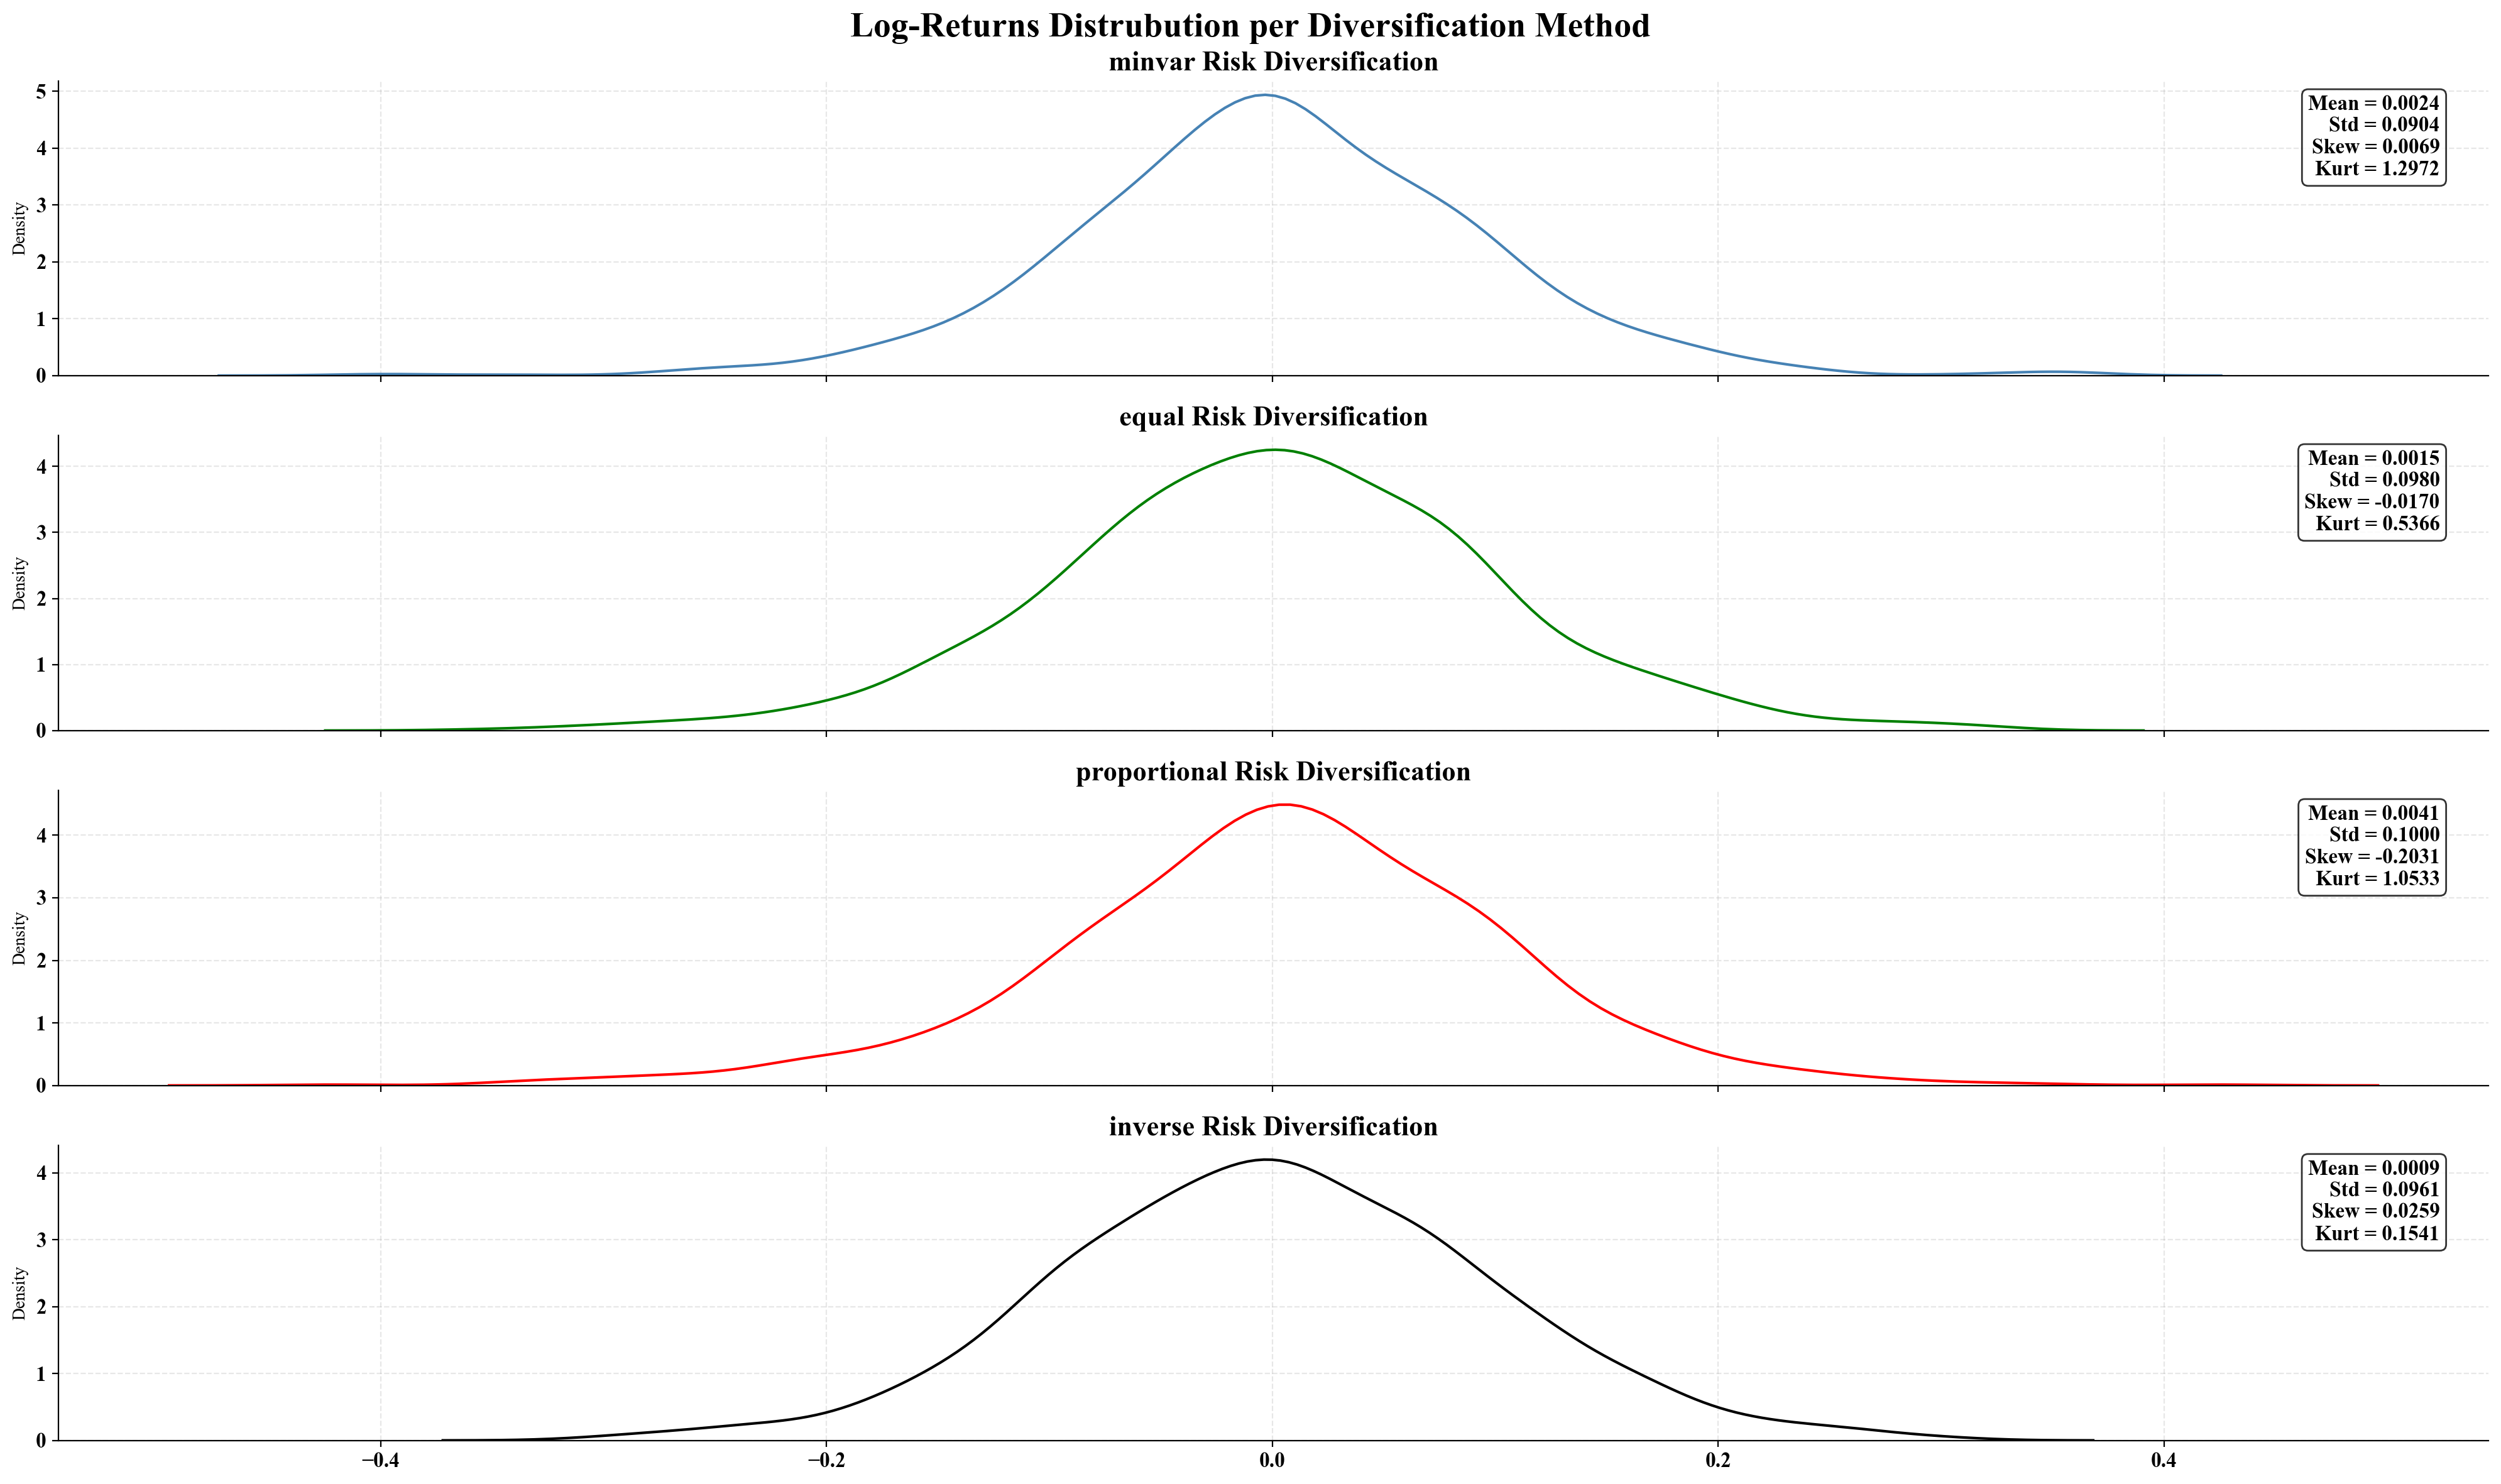

In [14]:
allocation = ['minvar', 'equal', 'proportional', 'inverse']
colors = ['steelblue', 'green', 'red', 'black']

pra_2 = PCARiskAllocator(logs.values,
                         logs=True)

fig, ax = plt.subplots(4, 1, figsize=(20,12), dpi=200, sharex=True)

for i, d in enumerate(allocation):
    pra_2.fit(risk_target=0.1,
              allocation=d)
    p = pra_2.portfolio
    
    sns.kdeplot(p, ax=ax[i], color=colors[i])
    
    mu = np.mean(p)
    sigma = np.std(p)
    skw = skew(p)
    krt = kurtosis(p)
    
    stats_text = (
        f"Mean = {mu:.4f}\n"
        f"Std = {sigma:.4f}\n"
        f"Skew = {skw:.4f}\n"
        f"Kurt = {krt:.4f}"
    )
    ax[i].text(0.98, 0.95, stats_text,
               transform=ax[i].transAxes,
               fontsize=12, weight='bold',
               va='top', ha='right',
               bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
    
    ax[i].set_title(f'{d} Risk Diversification',
                   size=16, weight='bold')
    ax[i].grid(ls='--', alpha=.3)

    for label in ax[i].get_yticklabels():
        label.set_fontsize(12)
        label.set_weight('bold')
        
for label in ax[3].get_xticklabels():
    label.set_fontsize(12)
    label.set_weight('bold')

fig.suptitle('Log-Returns Distrubution per Diversification Method',
            size=20, weight='bold')
plt.tight_layout()
sns.despine()
plt.show()

# 6. Cumulative Log-Returns Across Diversification Methods

To evaluate the long-term behavior of portfolios under different diversification schemes,  
we compare the **cumulative log-returns** of each portfolio against the underlying assets.

### Experiment Setup
- Four diversification strategies were applied:  
  - `minvar`  
  - `equal`  
  - `proportional`  
  - `inverse`  
- Each portfolio was scaled to a target volatility of $\sigma^* = 0.1$.  
- The cumulative sum of log-returns was plotted for each portfolio and overlaid with the cumulative log-returns of the individual assets (shown in light colors for reference).

---

### Visualization
- **Colored bold lines**: cumulative portfolio returns under each diversification method.  
- **Faint background lines**: cumulative log-returns of the individual assets in the dataset.  

---

### Insights
- The diversification method has a significant impact on long-term portfolio trajectories,  
  even when all are scaled to the same target volatility.  
- **`proportional`** and **`equal`** allocations tend to produce higher peaks but also sharper drawdowns.  
- **`minvar`** produces smoother but less aggressive growth, reflecting its concentration in the lowest-variance component.  
- **`inverse`** lies between the two extremes, offering more balanced exposure to low-variance directions.


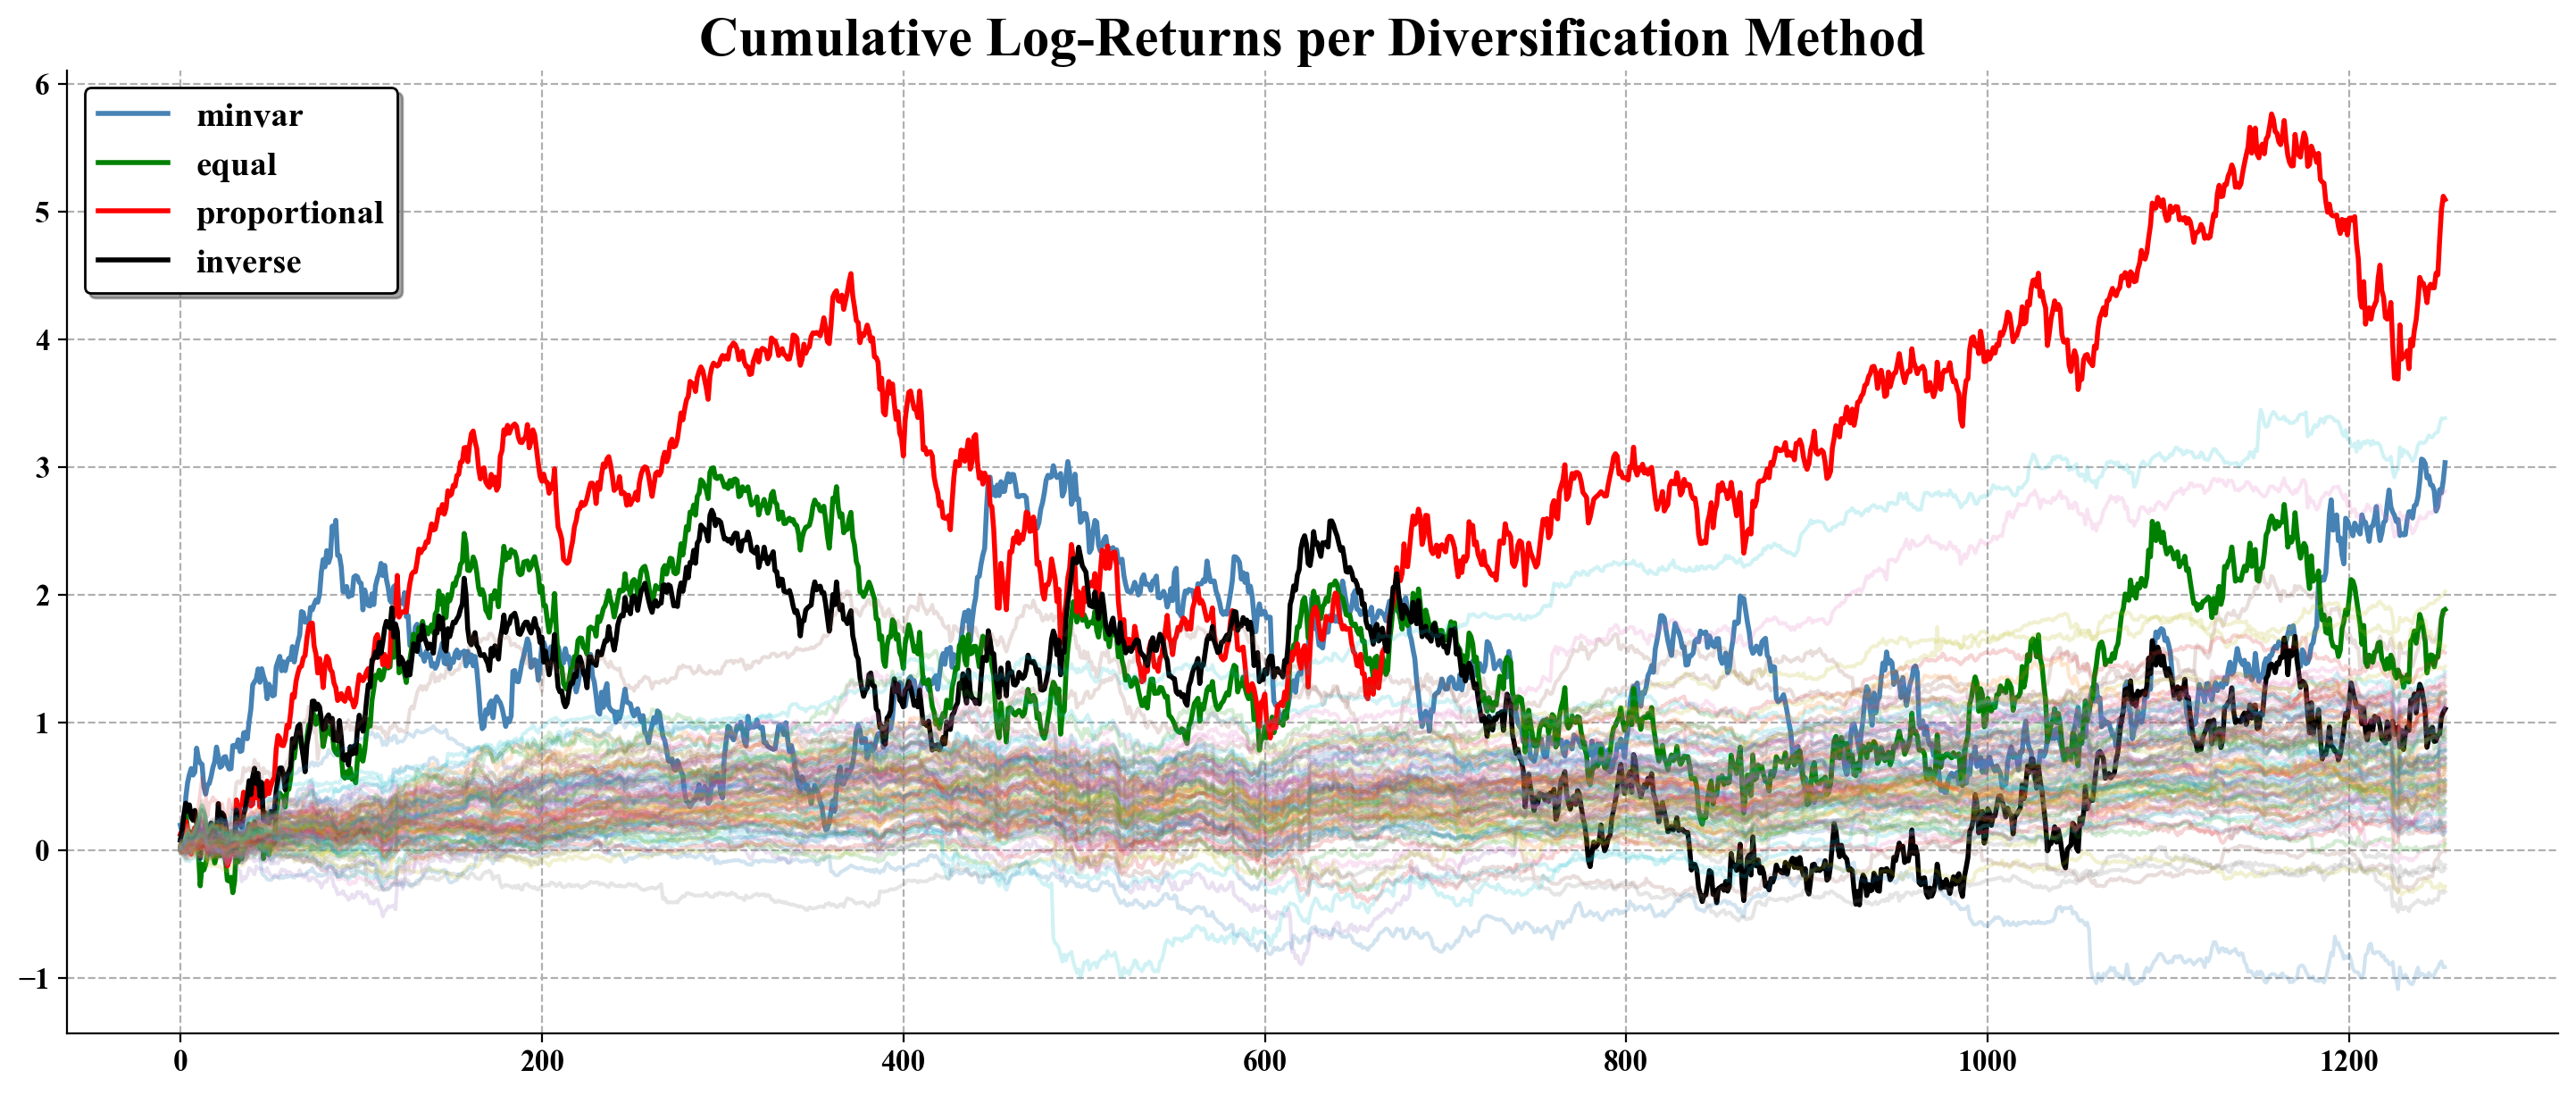

In [15]:
allocation = ['minvar', 'equal', 'proportional', 'inverse']
colors = ['steelblue', 'green', 'red', 'black']

pra_3 = PCARiskAllocator(logs.values,
                         logs=True)


plt.figure(figsize=(18,7), dpi=200)
for i, d in enumerate(allocation):
    pra_3.fit(risk_target=0.1,
              allocation=d)
    cp = pra_3.portfolio.cumsum()
    plt.plot(cp,
            color=colors[i],
            label=d,
            lw=2)

plt.plot(logs.values.cumsum(axis=0), alpha=.2)

plt.xticks(size=12, weight='bold')
plt.yticks(size=12, weight='bold')


plt.title('Cumulative Log-Returns per Diversification Method',
         size=22, weight='bold')
plt.grid(ls='--')
plt.legend(edgecolor='k',
          shadow=True,
          prop={'size': 14,
               'weight':'bold'})
sns.despine()
plt.show()